In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x  "/content/drive/My Drive/IITR.rar" -d "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/IITR/Train/Mask/mask/V0031_S012_034_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S013_035_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S014_036_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S015_037_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S016_038_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S017_039_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S018_040_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S019_041_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S020_042_seg.png          82%  OK 
Extracting  /content/IITR/Train/Mask/mask/V0031_S021_043_seg.png          82%  OK 
Extracting  /content/IITR/Tra

In [3]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from tensorflow import keras
from keras.optimizers import Nadam, Adam, SGD
from keras.models import Model, Sequential, Input
from keras import backend as K
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from scipy import ndimage
from scipy import misc
from skimage import exposure


In [4]:
SEED = 909
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 16

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = '/content/IITR'
data_dir_train = os.path.join(data_dir, 'Train')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'Img')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'Mask')

data_dir_test = os.path.join(data_dir, 'Val')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'Img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'Mask')

#print(f"train: {len(os.listdir(data_dir_train_image))}")
#print(f"test: {len(os.listdir(data_dir_test_image))}")
#NUM_TEST = 774

NUM_OF_EPOCHS = 100


In [10]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                      rotation_range=10,
                      width_shift_range=0.1,
                     height_shift_range=0.1,
                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None,color_mode='grayscale',  batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None,color_mode='grayscale',  batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None,color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None,color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [11]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 3982 images belonging to 1 classes.
Found 3982 images belonging to 1 classes.
Found 789 images belonging to 1 classes.
Found 789 images belonging to 1 classes.


In [12]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [13]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        print(image.shape)
        display([image[0], mask[0]])

(16, 256, 256, 1)


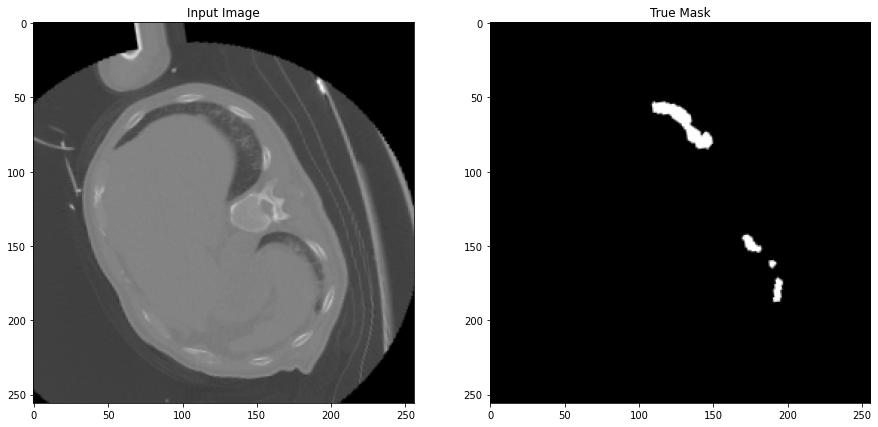

(16, 256, 256, 1)


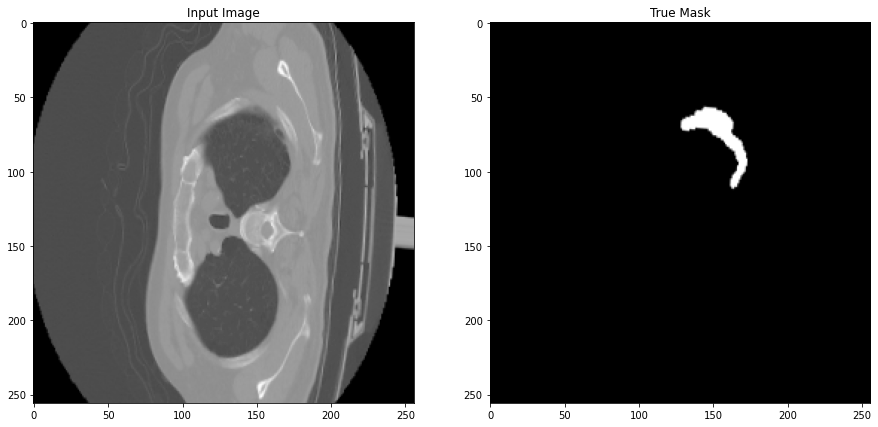

In [15]:
show_dataset(train_generator, 2)

In [21]:
pip install segmentation_models

     |████████████████████████████████| 51kB 4.5MB/s 


In [22]:
%env SM_FRAMEWORK=tf.keras
import keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [23]:
keras.backend.set_image_data_format('channels_last')

In [22]:
import segmentation_models as sm
print(keras.__version__)

2.4.3


In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [17]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [18]:
def jaccard_loss(y_true, y_pred):
    smooth = 100
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
def BCDU_net_D3():
    N = 256
    inputs = Input(shape = (256,256,1)) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)
    metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]
    model.compile(Adam(0.001),sm.losses.bce_jaccard_loss,metrics)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = jaccard_loss , metrics = [ iou, f1])    
    return model


In [29]:
model = BCDU_net_D3()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_41[0][0]                  
____________________________________________________________________________________________

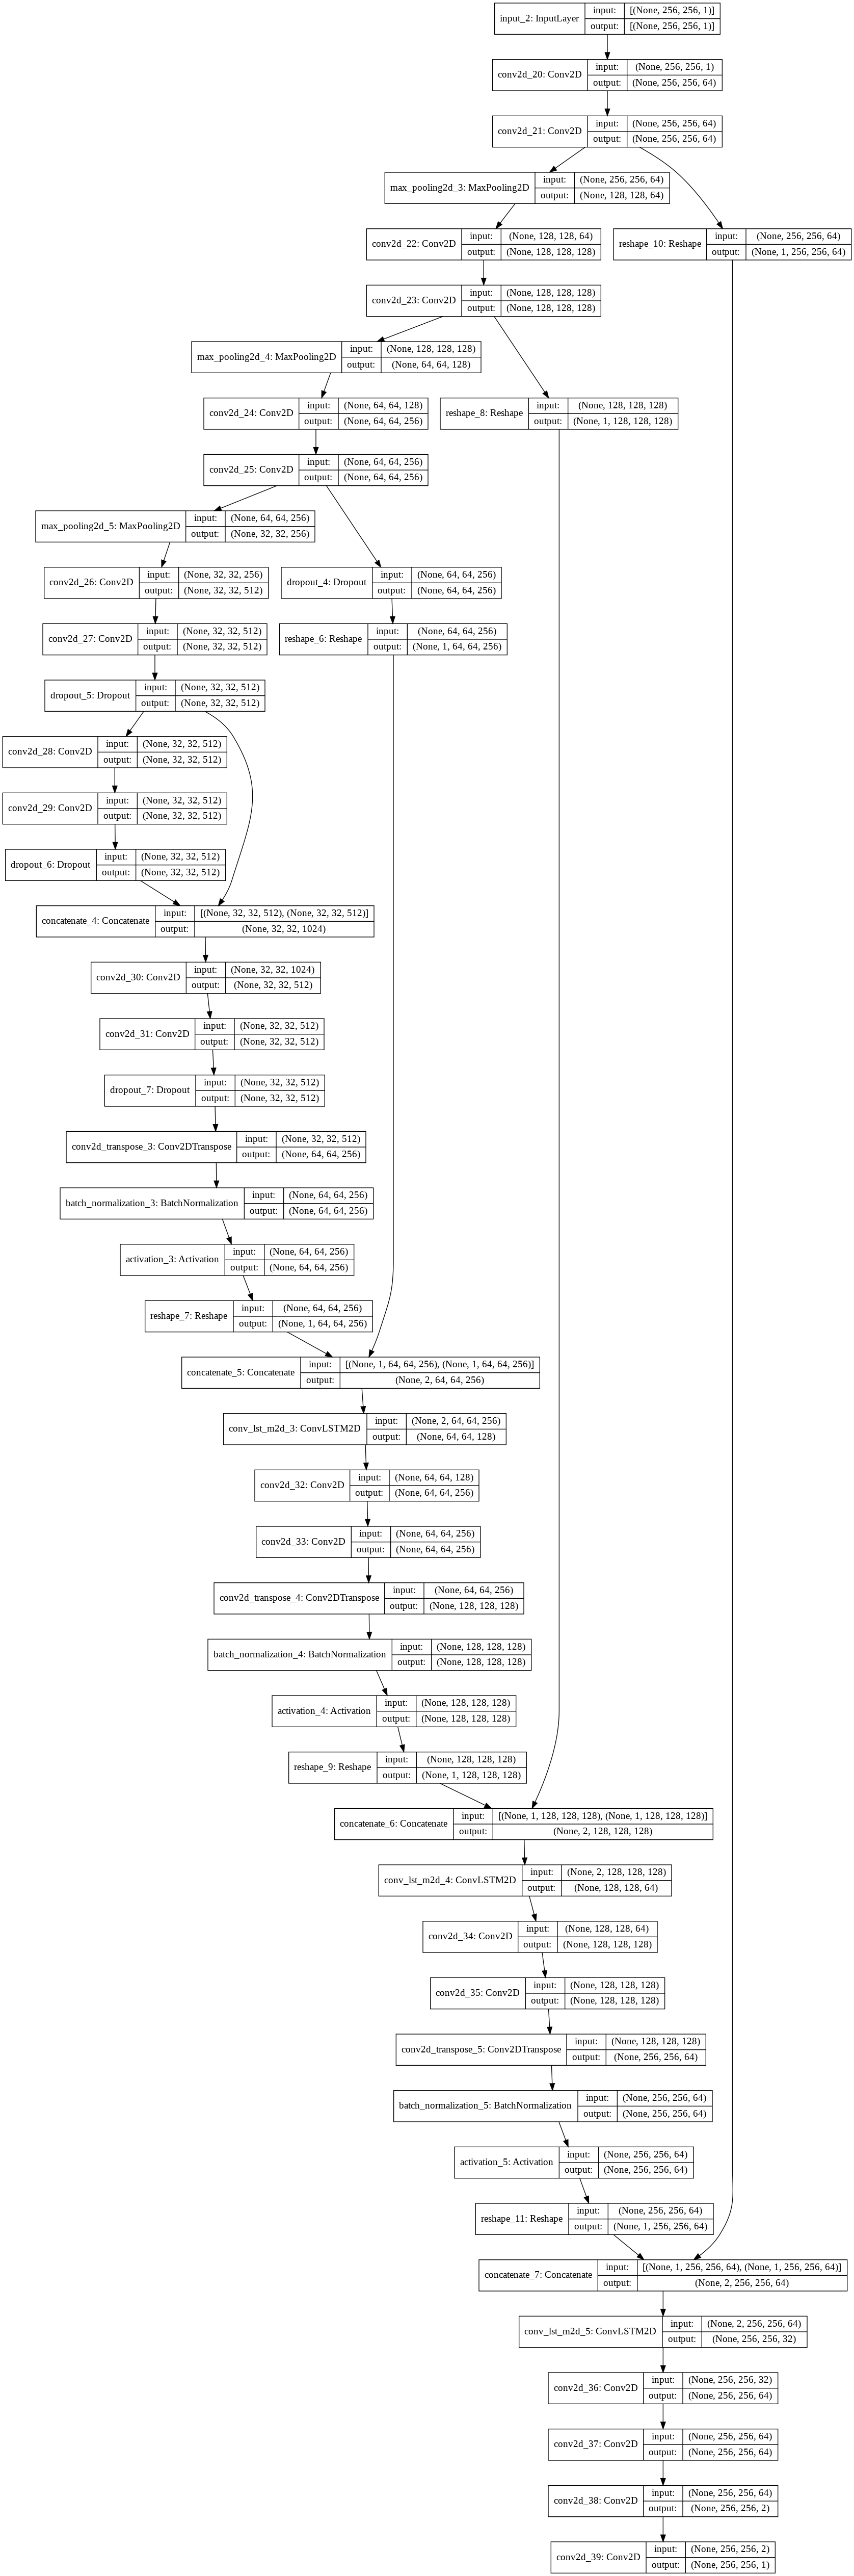

In [26]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
   
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [30]:
EPOCH_STEP_TRAIN = 3982 // 16
EPOCH_STEP_TEST = 789 // 16
#model_checkpoint = ModelCheckpoint('iitr_lung_unet.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.hdf5',  save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_loss',factor=0.5, patience=5, min_lr=0.000001),
]
history  = model.fit_generator(generator=train_generator, steps_per_epoch=EPOCH_STEP_TRAIN,
                   validation_data=test_generator,validation_steps=EPOCH_STEP_TEST,callbacks=callbacks,
                   epochs=100)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
248/248 [==============================] - 281s 1s/step - loss: 1.0779 - iou_score: 0.0372 - f1-score: 0.0689 - val_loss: 0.8329 - val_iou_score: 0.2154 - val_f1-score: 0.3516
Epoch 2/100
248/248 [==============================] - 271s 1s/step - loss: 0.8424 - iou_score: 0.2180 - f1-score: 0.3526 - val_loss: 0.9551 - val_iou_score: 0.1335 - val_f1-score: 0.2334
Epoch 3/100
248/248 [==============================] - 271s 1s/step - loss: 0.7828 - iou_score: 0.2726 - f1-score: 0.4230 - val_loss: 0.8685 - val_iou_score: 0.1853 - val_f1-score: 0.3085
Epoch 4/100
248/248 [==============================] - 271s 1s/step - loss: 0.7872 - iou_score: 0.2693 - f1-score: 0.4198 - val_loss: 0.7839 - val_iou_score: 0.2637 - val_f1-score: 0.4132
Epoch 5/100
248/248 [==============================] - 271s 1s/step - loss: 0.7593 - iou_score: 0.2946 - f1-score: 0.4489 - val_loss: 0.7999 - val_iou_score: 0.2482 - val_f1-score: 0.3937
Epoch 6/100
248/248 [==============================] - 271s 

Text(0.5, 1.0, 'model F1')

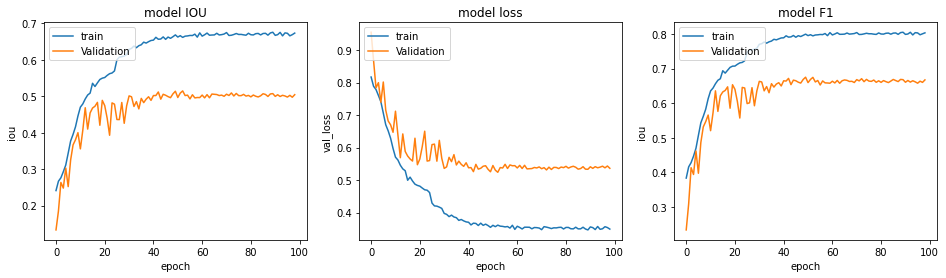

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(history.history['iou_score'][1:])
plt.plot(history.history['val_iou_score'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')


plt.subplot(1,3,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')

plt.subplot(1,3,3)
plt.plot(history.history['f1-score'][1:])
plt.plot(history.history['val_f1-score'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model F1')

In [60]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 789 images belonging to 1 classes.
Found 789 images belonging to 1 classes.


In [61]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

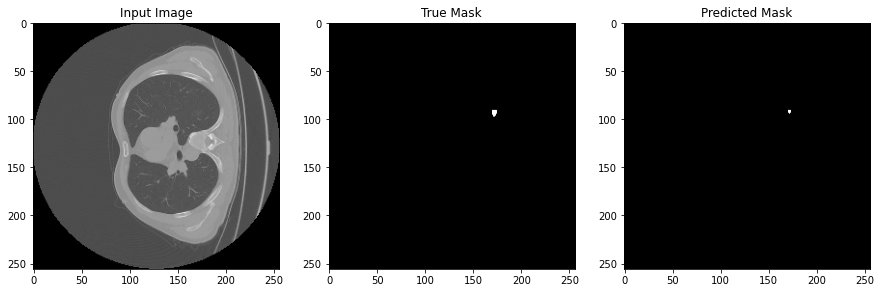

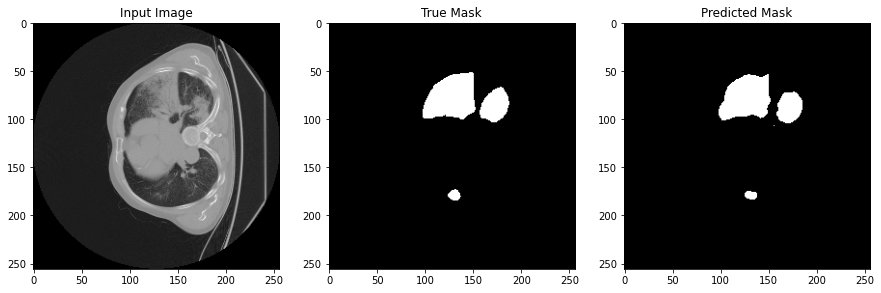

In [53]:
show_prediction(test_generator, 2)


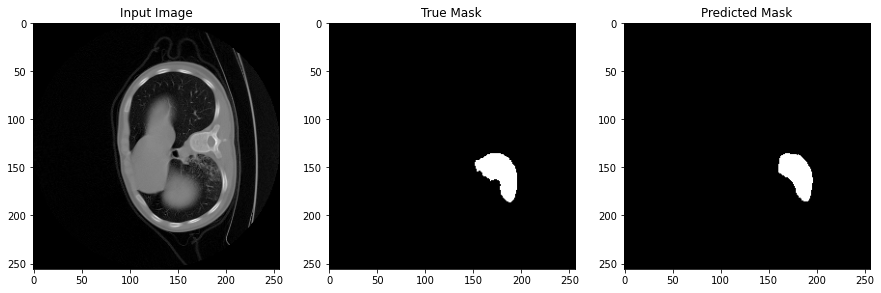

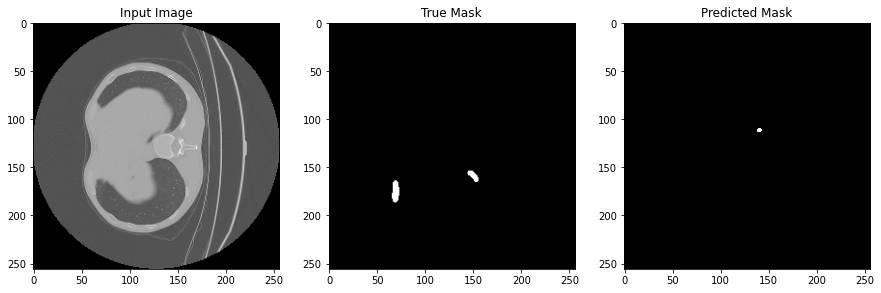

In [64]:
show_prediction(test_generator, 2)